In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset, random_split
import mne
import os
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
if torch.cuda.is_available():
    dev = "cuda:0"
else:
    dev = "cpu"
device = torch.device(dev)

In [45]:
class EEGDataset(Dataset):
    def __init__(self, data_dir, get_annotation, data_extension='edf', filter=None, target_filter=None, drop_channels=None):
        self.data_dir = data_dir
        self.get_annotation = get_annotation
        all_dir_files = os.listdir(data_dir)
        self.data_files_path = [file for file in all_dir_files if file.endswith(f'.{data_extension}')]
        self.filter = filter
        self.target_filter = target_filter
        self.drop_channels = drop_channels

    def __len__(self):
        return len(self.data_files_path)

    def __getitem__(self, idx):
        file_path = f'{self.data_dir}\\{self.data_files_path[idx]}'
        eeg = mne.io.read_raw_edf(file_path, preload=True, verbose=False)
        if self.drop_channels:
            eeg.drop_channels(self.drop_channels)
        label = get_annotation(file_path)
        if self.filter:
            eeg = self.filter(eeg)
        if self.target_filter:
            label = self.target_filter(label)
        if isinstance(eeg, mne.io.edf.edf.RawEDF):
            eeg = eeg.get_data()
        elif not isinstance(eeg, np.ndarray):
            eeg = np.array(eeg)
        eeg = eeg.astype(np.float32)
        label = np.int64(label)
        return eeg, label


def get_annotation(eeg_path: str, data_extension: str = 'edf') -> int:
    if eeg_path.endswith(f'_1.{data_extension}'):
        return 0
    elif eeg_path.endswith(f'_2.{data_extension}'):
        return 1
    raise Exception('Неизвестный формат файла')

def filter_data_func(*filters):
    def _filter_data(data):
        for filt in filters:
            data = filt(data)
        return data
    return _filter_data

def crop_eeg_func(size):
    def _crop(data):
        return data.crop(tmax=size, include_tmax=False)
    return _crop

def freq_mean_func(freqs):
    def _freq_mean(data):
        data_freqs = []  # По-хорошему словарь сюда бы
        for freq_l, freq_r in freqs:
            copy_data = data.copy()
            copy_data.filter(freq_l,
                             freq_r,
                             n_jobs=None,  # use more jobs to speed up.
                             l_trans_bandwidth=1,  # make sure filter params are the same
                             h_trans_bandwidth=1,
                             verbose=False)
            data_freqs.append(copy_data.get_data().mean(axis=1))
        return np.array(data_freqs)
    return _freq_mean

def normalize(data):
    mean = data.mean()
    std = data.std()
    return (data-mean)/std

def normalize_minmax(data):
    min = data.min()
    max = data.max()
    
    return (data-min)/(max-min)

In [3]:
class StressRecognitionNetwork(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.flatten = nn.Flatten(1)
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 16),
            nn.ReLU(),
            nn.Linear(16, 2),
        )

    def forward(self, x):
        # x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

# model = Sequential([
#     Input(shape=(X_train.shape[1],)),
#     Dense(256, activation='relu'),
#     Dropout(0.5),
#     Dense(128, activation='relu'),
#     Dropout(0.5),
#     Dense(2, activation='softmax')
# ])

In [4]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        optimizer.zero_grad()
        pred = model(X.to(device))
        # print(pred)
        # print(y)
        loss = loss_fn(pred, y.to(device))

        loss.backward()
        optimizer.step()

        if batch % 5 == 0:
            loss = loss.item()
            current = batch * batch_size + len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")



def test_loop(dataloader, model, loss_fn):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, accuracy = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X.to(device))
            test_loss += loss_fn(pred, y.to(device)).item()
            # print((pred.detach().cpu().argmax() == y).type(torch.float).sum().item())
            accuracy += (pred.detach().cpu().argmax(dim=1) == y).type(torch.float).sum().item()
            # print(f'{pred=}')
            # print(f'{y.data=}')
            
    # test_loss /= num_batches
    test_loss /= size
    accuracy /= size
    print(f"Test Error: \n Accuracy: {(100*accuracy):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return test_loss, accuracy

In [78]:
learning_rate = 1e-3
batch_size = 32
epochs = 100
best_model_path = 'best-model-parameters.pt'

In [73]:
# with open(r"C:\Перенос\Доки\Мага брат\Методология научных исследований\ВКР\Отфильтрованные записи\Признаки\features_01.npy", mode='rb') as f:
#     features = np.load(f)
with open(r"C:\Перенос\Доки\Мага брат\Методология научных исследований\ВКР\Отфильтрованные записи\Признаки\features_02.npy", mode='rb') as f:
    features = np.load(f)

In [37]:
# features[:, 1:] = normalize(features[:, 1:])

In [50]:
# features[:, 1:] = normalize_minmax(features[:, 1:])

In [97]:
X_train, X_test, y_train, y_test = train_test_split(features[:, 1:], features[:, 0], test_size=0.5, random_state=100)

In [144]:
# X_test, y_test, X_valid, y_valid = X_test[:100], y_test[:100], X_test[100:], y_test[100:]

In [98]:
train = torch.tensor(X_train.astype(np.float32))
train_target = torch.tensor(y_train, dtype=torch.long)
train_dataset = torch.utils.data.TensorDataset(train, train_target)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

test = torch.tensor(X_test.astype(np.float32))
test_target = torch.tensor(y_test, dtype=torch.long)
test_dataset = torch.utils.data.TensorDataset(test, test_target)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

In [99]:
input_size = X_train.shape[1]
stress_nn = StressRecognitionNetwork(input_size)
stress_nn.to(device)

StressRecognitionNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=352, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=16, bias=True)
    (7): ReLU()
    (8): Linear(in_features=16, out_features=2, bias=True)
  )
)

In [100]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(stress_nn.parameters(), lr=learning_rate)
test_losses, accuracies = [], []
best_accuracy = 0

for i in range(1, epochs+1):
    print(f"Epoch {i}\n-------------------------------")
    train_loop(train_loader, stress_nn, loss_fn, optimizer)
    test_loss, accuracy = test_loop(test_loader, stress_nn, loss_fn)
    test_losses.append(test_loss)
    accuracies.append(accuracy)
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        torch.save(stress_nn.state_dict(), best_model_path)
    
print("Done!")

Epoch 1
-------------------------------
loss: 1.312490  [   32/  167]
loss: 1.265317  [  167/  167]
Test Error: 
 Accuracy: 60.5%, Avg loss: 0.029201 

Epoch 2
-------------------------------
loss: 1.176088  [   32/  167]
loss: 0.849218  [  167/  167]
Test Error: 
 Accuracy: 66.5%, Avg loss: 0.022968 

Epoch 3
-------------------------------
loss: 0.733409  [   32/  167]
loss: 0.692807  [  167/  167]
Test Error: 
 Accuracy: 67.7%, Avg loss: 0.027293 

Epoch 4
-------------------------------
loss: 0.595097  [   32/  167]
loss: 0.481742  [  167/  167]
Test Error: 
 Accuracy: 74.3%, Avg loss: 0.016698 

Epoch 5
-------------------------------
loss: 0.406567  [   32/  167]
loss: 0.135473  [  167/  167]
Test Error: 
 Accuracy: 75.4%, Avg loss: 0.016179 

Epoch 6
-------------------------------
loss: 0.320618  [   32/  167]
loss: 0.544026  [  167/  167]
Test Error: 
 Accuracy: 77.2%, Avg loss: 0.021085 

Epoch 7
-------------------------------
loss: 0.450827  [   32/  167]
loss: 0.456232  [ 

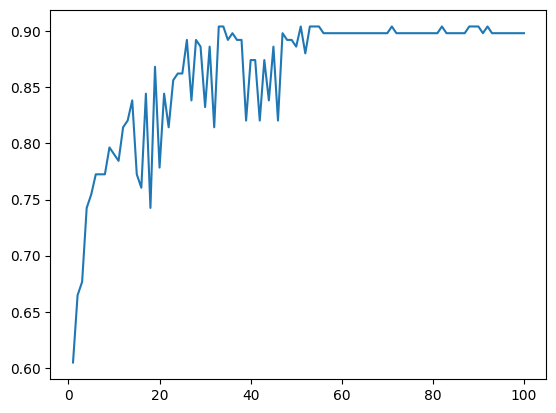

In [101]:
plt.plot(range(1, len(accuracies)+1), accuracies)

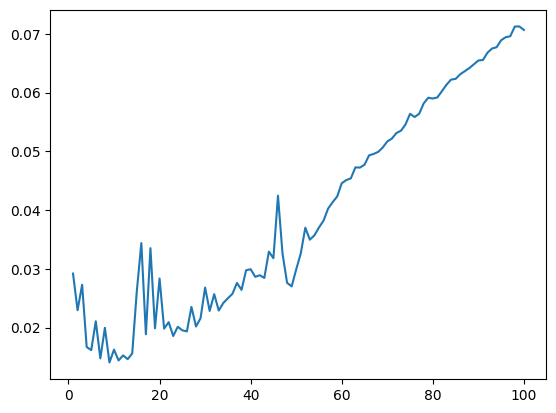

In [102]:
plt.plot(range(1, len(test_losses)+1), test_losses)

In [112]:
stress_nn.load_state_dict(torch.load(best_model_path))

<All keys matched successfully>

In [113]:
y_test = []
y_pred = []
for X, y in test_loader:
    y_test.extend(y)
    pred = stress_nn(X.to(device))
    y_pred.extend(pred.detach().cpu().argmax(dim=1))
cm = confusion_matrix(y_test, y_pred)
clr = classification_report(y_test, y_pred, target_names=['Stress', 'Not stress'])
print(clr)

              precision    recall  f1-score   support

      Stress       0.91      0.93      0.92        97
  Not stress       0.90      0.87      0.88        70

    accuracy                           0.90       167
   macro avg       0.90      0.90      0.90       167
weighted avg       0.90      0.90      0.90       167



In [125]:
x = test_loader.dataset.tensors[0][10]

In [163]:
%%timeit -r 20 -n 5
stress_nn(X.to(device)).detach().cpu().argmax()

852 µs ± 119 µs per loop (mean ± std. dev. of 20 runs, 5 loops each)


In [106]:
print(stress_nn)

StressRecognitionNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=352, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=16, bias=True)
    (7): ReLU()
    (8): Linear(in_features=16, out_features=2, bias=True)
  )
)


In [83]:
cm

array([[88,  9],
       [ 7, 63]], dtype=int64)

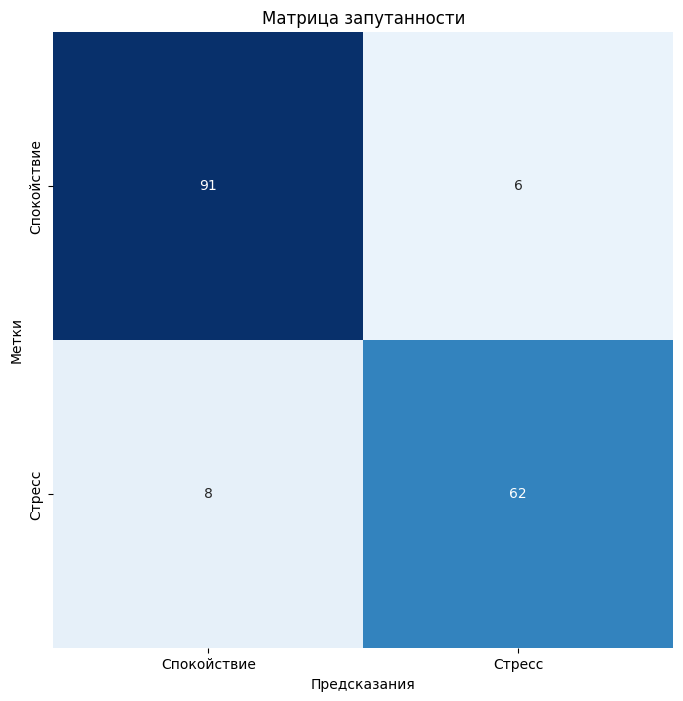

Classification Report:
----------------------
               precision    recall  f1-score   support

      Stress       0.92      0.94      0.93        97
  Not stress       0.91      0.89      0.90        70

    accuracy                           0.92       167
   macro avg       0.92      0.91      0.91       167
weighted avg       0.92      0.92      0.92       167



In [115]:
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, vmin=0, fmt='g', cbar=False, cmap='Blues')
plt.xticks(np.arange(2) + 0.5, ['Спокойствие', 'Стресс'])
plt.yticks(np.arange(2) + 0.5, ['Спокойствие', 'Стресс'])
plt.xlabel("Предсказания")
plt.ylabel("Метки")
plt.title("Матрица запутанности")
plt.show()

print("Classification Report:\n----------------------\n", clr)

In [35]:
with open(r"C:\Перенос\Доки\Мага брат\Методология научных исследований\ВКР\Отфильтрованные записи\Признаки\features_stress_masha_01.npy", mode='rb') as f:
    features_stress = np.load(f)

In [108]:
with open(r"C:\Перенос\Доки\Мага брат\Методология научных исследований\ВКР\Отфильтрованные записи\Признаки\features_stress_masha_01.npy", mode='rb') as f:
    features_stress = np.load(f)

In [84]:
with open(r"C:\Перенос\Доки\Мага брат\Методология научных исследований\ВКР\Отфильтрованные записи\Признаки\features_relax_masha_01.npy", mode='rb') as f:
    features_relax = np.load(f)

In [104]:
# X_valid, y_valid = features_relax[:, 1:], features_relax[:, 0]
X_valid, y_valid = features_relax[42:, 1:], features_relax[42:, 0]

In [109]:
X_valid, y_valid = features_stress[5:, 1:], features_stress[5:, 0]


In [26]:
X_valid.shape

(180, 352)

In [110]:
valid = torch.tensor(X_valid.astype(np.float32))
valid_target = torch.tensor(y_valid, dtype=torch.long)
valid_dataset = torch.utils.data.TensorDataset(valid, valid_target)
valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

In [114]:
y_test = []
y_pred = []
for X, y in valid_loader:
    y_test.extend(y)
    pred = stress_nn(X.to(device))
    y_pred.extend(pred.detach().cpu().argmax(dim=1))
cm = confusion_matrix(y_test, y_pred)
clr = classification_report(y_test, y_pred)
# clr = classification_report(y_test, y_pred, target_names=['Stress', 'Not stress'])
print(clr)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.93      0.97        60

    accuracy                           0.93        60
   macro avg       0.50      0.47      0.48        60
weighted avg       1.00      0.93      0.97        60



C:\Users\Арсений\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Арсений\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Арсений\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

In [107]:
cm

array([[98, 40],
       [ 0,  0]], dtype=int64)

In [91]:
all_y_test.extend(y_test)
all_y_pred.extend(y_pred)

NameError: name 'all_y_test' is not defined

In [51]:
clr = classification_report(all_y_test, all_y_pred)
print(clr)

              precision    recall  f1-score   support

           0       0.97      0.81      0.89       138
           1       0.69      0.95      0.80        60

    accuracy                           0.85       198
   macro avg       0.83      0.88      0.84       198
weighted avg       0.89      0.85      0.86       198



In [96]:
cm

array([[100,  38],
       [  0,   0]], dtype=int64)

In [9]:
data_path = "C:\Перенос\Доки\Мага брат\Методология научных исследований\ВКР\eeg-during-mental-arithmetic-tasks-1.0.0\eeg-during-mental-arithmetic-tasks-1.0.0"

In [63]:
freqs = [(0, 4), 
         (4, 8),
         (8, 12),
         (12, 30),
         (30, 45)]
data_time = 62
seq_filters = filter_data_func(crop_eeg_func(data_time), 
                               freq_mean_func(freqs),
                               normalize)
dataset = EEGDataset(data_dir=data_path, get_annotation=get_annotation, filter=seq_filters, drop_channels='ECG ECG')

generator = torch.Generator().manual_seed(42)
training_data, test_data = random_split(dataset, [0.7, 0.3], generator)

train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

In [64]:
dataset[0][0].size

100

In [65]:
input_size = dataset[0][0].size
stress_nn = StressRecognitionNetwork(input_size)
stress_nn.to(device)

StressRecognitionNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=100, out_features=54, bias=True)
    (1): ReLU()
    (2): Linear(in_features=54, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=16, bias=True)
    (5): ReLU()
    (6): Linear(in_features=16, out_features=8, bias=True)
    (7): ReLU()
    (8): Linear(in_features=8, out_features=2, bias=True)
  )
)

In [66]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(stress_nn.parameters(), lr=learning_rate)

for i in range(1, epochs+1):
    print(f"Epoch {i}\n-------------------------------")
    train_loop(train_dataloader, stress_nn, loss_fn, optimizer)
    test_loop(test_dataloader, stress_nn, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 0.680595  [    4/   51]
loss: 0.674236  [   24/   51]
loss: 0.725456  [   44/   51]
Test Error: 
 Accuracy: 9.5%, Avg loss: 0.693719 

Epoch 2
-------------------------------
loss: 0.686244  [    4/   51]
loss: 0.701223  [   24/   51]
loss: 0.696340  [   44/   51]
Test Error: 
 Accuracy: 14.3%, Avg loss: 0.690719 

Epoch 3
-------------------------------
loss: 0.694919  [    4/   51]
loss: 0.694977  [   24/   51]
loss: 0.692036  [   44/   51]
Test Error: 
 Accuracy: 14.3%, Avg loss: 0.686150 

Epoch 4
-------------------------------
loss: 0.660753  [    4/   51]
loss: 0.694067  [   24/   51]
loss: 0.629243  [   44/   51]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.701009 

Epoch 5
-------------------------------
loss: 0.661830  [    4/   51]
loss: 0.677056  [   24/   51]
loss: 0.654388  [   44/   51]
Test Error: 
 Accuracy: 14.3%, Avg loss: 0.699605 

Epoch 6
-------------------------------
loss: 0.609258  [    4/   51]
loss: 0.565678  [   24

In [77]:
y_test = []
y_pred = []
for X, y in test_dataloader:
    y_test.extend(y)
    pred = stress_nn(X.to(device))
    y_pred.extend(pred.detach().cpu().argmax(dim=1))
    # print(pred.cpu().argmax(dim=1), y)

In [79]:
cm = confusion_matrix(y_test, y_pred)
clr = classification_report(y_test, y_pred, target_names=['Stress', 'Not stress'])

In [81]:
print(clr)

              precision    recall  f1-score   support

      Stress       0.60      0.67      0.63         9
  Not stress       0.73      0.67      0.70        12

    accuracy                           0.67        21
   macro avg       0.66      0.67      0.66        21
weighted avg       0.67      0.67      0.67        21



In [99]:
raw = dataset[0][0]

(21,)

In [100]:
raw.load_data()
raw.filter(
    4,
    7,
    n_jobs=None,  # use more jobs to speed up.
    l_trans_bandwidth=1,  # make sure filter params are the same
    h_trans_bandwidth=1)
raw.get_data().mean(axis=1).shape

Reading 0 ... 30999  =      0.000 ...    61.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 3.50 Hz)
- Upper passband edge: 7.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 7.50 Hz)
- Filter length: 1651 samples (3.302 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:    0.0s finished


Measurement date,"January 01, 2011 00:00:00 GMT"
Experimenter,Unknown
Participant,0
Digitized points,Not available
Good channels,21 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,500.00 Hz
Highpass,4.00 Hz
Lowpass,7.00 Hz


In [26]:
raw.get_data()[0]

array([-3.64793763e-06, -4.23648168e-06, -4.95421832e-06, ...,
       -1.42194009e-05, -1.42927696e-05, -1.41747417e-05])

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 4.096 (s)


C:\Users\Арсений\AppData\Local\Temp\ipykernel_13144\1678697157.py:1: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw.plot_psd(fmax=45)
C:\Users\Арсений\AppData\Local\Programs\Python\Python311\Lib\site-packages\mne\viz\utils.py:165: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


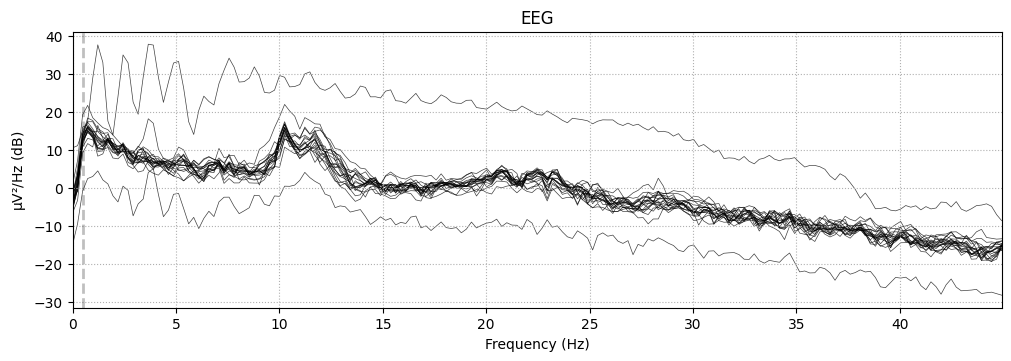

In [27]:
raw.plot_psd(fmax=45)

In [28]:
from scipy.fftpack import rfft, rfftfreq

In [98]:
freq_ix

array([60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76,
       77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90],
      dtype=int64)

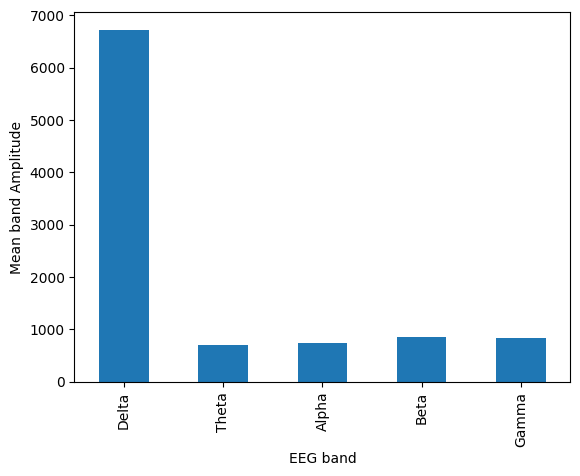

In [91]:
fs = 512                                # Sampling rate (512 Hz)
data = np.random.uniform(0, 100, 1024)  # 2 sec of data b/w 0.0-100.0

# fs = 250
# data = raw.get_data()

# Get real amplitudes of FFT (only in postive frequencies)
fft_vals = np.absolute(np.fft.rfft(data))

# Get frequencies for amplitudes in Hz
fft_freq = np.fft.rfftfreq(len(data), 1.0/fs)

# Define EEG bands
eeg_bands = {'Delta': (0, 4),
             'Theta': (4, 8),
             'Alpha': (8, 12),
             'Beta': (12, 30),
             'Gamma': (30, 45)}

# Take the mean of the fft amplitude for each EEG band
eeg_band_fft = dict()
eeg_band_fft_val = dict()
for band in eeg_bands:  
    freq_ix = np.where((fft_freq >= eeg_bands[band][0]) & 
                       (fft_freq <= eeg_bands[band][1]))[0]
    eeg_band_fft[band] = np.mean(fft_vals[freq_ix])
    eeg_band_fft_val[band] = fft_vals[freq_ix]

# Plot the data (using pandas here cause it's easy)
import pandas as pd
df = pd.DataFrame(columns=['band', 'val'])
df['band'] = eeg_bands.keys()
df['val'] = [eeg_band_fft[band] for band in eeg_bands]
ax = df.plot.bar(x='band', y='val', legend=False)
ax.set_xlabel("EEG band")
ax.set_ylabel("Mean band Amplitude")
plt.show()

C:\Users\Арсений\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Арсений\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


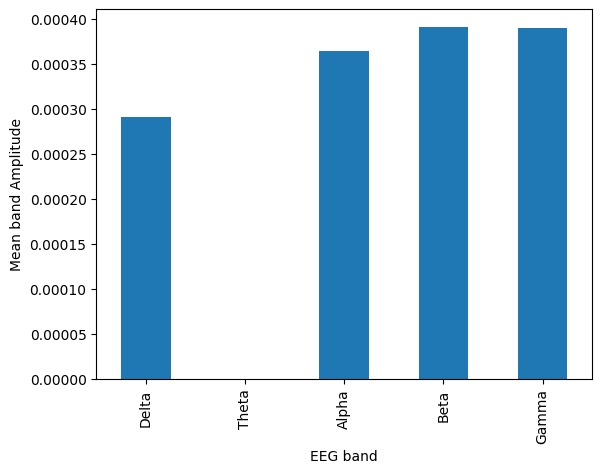

In [82]:
data = raw.get_data()
fft_vals = np.absolute(rfft(data))

# Get frequencies for amplitudes in Hz
fft_freq = rfftfreq(len(data), 1.0/250)

# Define EEG bands
eeg_bands = {'Delta': (0, 4),
             'Theta': (4, 8),
             'Alpha': (8, 12),
             'Beta': (12, 30),
             'Gamma': (30, 45)}

# Take the mean of the fft amplitude for each EEG band
eeg_band_fft = dict()
for band in eeg_bands:  
    freq_ix = np.where((fft_freq >= eeg_bands[band][0]) & 
                       (fft_freq <= eeg_bands[band][1]))[0]
    eeg_band_fft[band] = np.mean(fft_vals[freq_ix])

# Plot the data (using pandas here cause it's easy)
import pandas as pd
df = pd.DataFrame(columns=['band', 'val'])
df['band'] = eeg_bands.keys()
df['val'] = [eeg_band_fft[band] for band in eeg_bands]
ax = df.plot.bar(x='band', y='val', legend=False)
ax.set_xlabel("EEG band")
ax.set_ylabel("Mean band Amplitude")
plt.show()

In [33]:
from matplotlib import pyplot as plt

In [31]:
df

,band,val
0,Delta,0.000291
1,Theta,NaN
2,Alpha,0.000365
3,Beta,0.000391
4,Gamma,0.000390
